In [1]:
import os
os.environ['CC'] = 'gcc'
os.environ['CXX'] = 'g++'

import sys
sys.path.append('..')

import jax
import jax.numpy as jnp
import spark
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

# NOTE: Brian throws an error if we don't set a device 
#b2.set_device('cpp_standalone', build_on_run=False)

In [2]:
def summary_plot(times, input_spikes_times, output_spikes_times, potentials) -> None:
	fig, ax = plt.subplots(3, 1, figsize=(8,5))
	
	ax[0].eventplot(input_spikes_times)
	ax[0].set_ylabel('Input Spikes')

	ax[1].plot(times, potentials)
	ax[1].set_ylabel('Potential [mV]')
	
	ax[2].eventplot(output_spikes_times)
	ax[2].set_ylabel('Output Spikes')
	ax[2].set_xlabel('Time [ms]')

	for i in range(3):
		ax[i].set_xlim(0, times[-1])

	plt.tight_layout()
	plt.show()

def spikes_to_current(spike_times, k=1.0, t_max=100.0, dt=0.1):
    """
    	Convert spike times into a discrete current trace.
    """
    times = np.arange(0, t_max + dt, dt)
    currents = np.zeros_like(times)
    for s in spike_times:
        idx = int(round(s / dt))
        if 0 <= idx < len(currents):
            currents[idx] += k
    return times, currents

def spike_events_to_array(spikes, max_t, dt=0.1):
	times = np.linspace(0, max_t, int(max_t/dt)+1)
	array = np.zeros(times.shape)
	for s in spikes:
		array[int(s / dt)] = 1
	return times, array

@jax.jit
def run_model_split(graph, state, **inputs):
	model = spark.merge(graph, state)
	outputs = model(**inputs)
	_, state = spark.split((model))
	return outputs, state

In [3]:
DT = 0.1
V_REST = -70.0
V_RESET = -65.0
FIRING_THRESHOLD = -50
MEMBRANE_RESISTANCE = 10.0
MEMBRANE_TIME_SCALE = 8.0
ABSOLUTE_REFRACTORY_PERIOD = 2.0
INPUT_SPIKE_TIMES = [10, 20, 30, 32, 34, 36, 38, 55, 60, 62, 70, 84]

In [4]:
def simulate_LIF_from_spikes(
		spike_times,
		k,
		t_max,
		dt,
		v_rest,
		v_reset,
		firing_threshold,
		membrane_resistance,
		membrane_time_scale,
		abs_refractory_period,
	):
	"""
		Simulate a LIF neuron receiving discrete one-step current inputs from spikes.
	"""
	
	# Reset scope
	b2.start_scope()
	# Build discrete current trace from spikes
	times, currents = spikes_to_current(spike_times, k=k, t_max=t_max, dt=dt)
	input_current = b2.TimedArray(currents * b2.nA, dt=dt * b2.ms)
	eqs = """
		dv/dt = (-(v - v_rest) + membrane_resistance * input_current(t)) / membrane_time_scale : volt (unless refractory)
	"""
	neuron = b2.NeuronGroup(
		1, model=eqs, reset="v=v_reset", threshold="v>firing_threshold",
		refractory=abs_refractory_period, method="linear"
	)
	neuron.v = v_rest
	state_monitor = b2.StateMonitor(neuron, "v", record=True)
	spike_monitor = b2.SpikeMonitor(neuron)
	# Run simulation
	b2.run(t_max * b2.ms)
	# Get outputs
	times = state_monitor.t / b2.ms
	spikes = [s / b2.ms for s in spike_monitor.t]
	potentials = state_monitor.v[0] / b2.mV
	return times, potentials, spikes


# Build neuronal model
def build_lif_model():
	# NOTE: We need to substract 1 timestep from the cooldown to match the Brian2 dynamic 
	# Since we update the refractory the period at the end of the cycle, Brian2 does it at the begining. 
	lif_neuron = spark.nn.neurons.LIFNeuron(
		_s_units = (1,),
		_s_dt = DT,
		_s_dtype = jnp.float32,
		async_spikes = False,
		inhibitory_rate = 0.0,
		soma_config = spark.nn.somas.StrictRefractoryLeakySomaConfig(
			potential_rest = V_REST,
			potential_reset = V_RESET,
			potential_tau = MEMBRANE_TIME_SCALE,
			resistance = MEMBRANE_RESISTANCE,
			threshold = FIRING_THRESHOLD,
			cooldown = ABSOLUTE_REFRACTORY_PERIOD - DT, 
		),
		synapses_config = spark.nn.synapses.LinearSynapsesConfig(
			units = (1,),
			kernel_initializer = spark.nn.initializers.ConstantInitializerConfig(scale=75000.0),
		),
		delays_config = None,
		learning_rule_config = None,
	)
	lif_neuron(in_spikes=spark.SpikeArray( jnp.zeros((1,)) ))
	return lif_neuron

In [5]:
# Run Brian2 model
b2_times, b2_potentials, b2_spikes = simulate_LIF_from_spikes(
	INPUT_SPIKE_TIMES,
	k=75.0,
	t_max=100.0,
	dt=DT,
	v_rest=V_REST * b2.mV,
	v_reset=V_RESET * b2.mV,
	firing_threshold=FIRING_THRESHOLD * b2.mV,
	membrane_resistance=MEMBRANE_RESISTANCE * b2.Mohm,
	membrane_time_scale=MEMBRANE_TIME_SCALE * b2.ms,
	abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD * b2.ms
)

# Run Spark model
lif_neuron = build_lif_model()
graph, state = spark.split((lif_neuron))
spark_times, in_spikes = spike_events_to_array(INPUT_SPIKE_TIMES, 100, dt=DT)
spark_spikes, spark_potentials = [], []
refractory_value = []
for s in in_spikes:
	in_spikes = spark.SpikeArray( jnp.array([s]) )
	outputs, state = run_model_split(graph, state, in_spikes=in_spikes)
	spark_spikes.append(np.array(outputs['out_spikes'].value))
	model = spark.merge(graph, state)
	spark_potentials.append(np.array(model.soma.potential.value) + V_REST)
	refractory_value.append(np.array(model.soma.refractory.value))
spark_spikes = [t*DT for t, s in enumerate(spark_spikes) if s == 1]

/home/nogar/.cython/brian_extensions/_cython_magic_19f1946bd0f8954cc2d65b075af8288b.cpp:50:10: fatal error: Python.h: No such file or directory
   50 | #include "Python.h"
      |          ^~~~~~~~~~
compilation terminated.
WARNING    Cannot use Cython, a test compilation failed: command '/usr/bin/g++' failed with exit code 1 (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


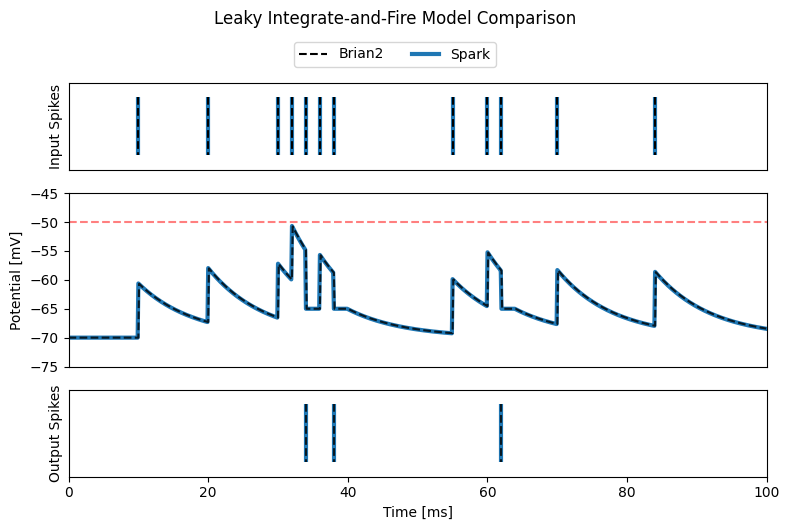

In [45]:
fig, ax = plt.subplots(3, 1, figsize=(8,5), height_ratios=(1,2,1))

ax[0].eventplot(INPUT_SPIKE_TIMES, linewidth=3)
ax[0].eventplot(INPUT_SPIKE_TIMES, color='k', linestyles='--')
ax[0].set_ylabel('Input Spikes')
ax[0].set_ylim(0.25,1.75)
ax[0].set_yticks([], [])
ax[0].set_xticks([], [])

ax[1].plot([0, 100], [FIRING_THRESHOLD, FIRING_THRESHOLD], 'r--', alpha=0.5)
ax[1].plot(spark_times, spark_potentials, linewidth=3)
ax[1].plot(b2_times, b2_potentials, 'k--', alpha=0.8)
ax[1].set_ylabel('Potential [mV]')
ax[1].set_ylim(-75,-45)
ax[1].set_xticks([], [])

ax[2].eventplot(spark_spikes, linewidths=3)
ax[2].eventplot(b2_spikes, color='k', linestyles='--', alpha=0.8)
ax[2].set_ylabel('Output Spikes')
ax[2].set_yticks([], [])
ax[2].set_ylim(0.25,1.75)
ax[2].set_xlabel('Time [ms]')

for i in range(3):
	ax[i].set_xlim(0, spark_times[-1])

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
	Line2D([], [], color='k', linestyle='--', label='Brian2'), 
	Line2D([], [], linestyle='solid', linewidth=3, label='Spark'), 
]
legend = fig.legend(handles=legend_elements, ncols=2, bbox_to_anchor=(0.5, 1.0), loc='upper center')

plt.suptitle('Leaky Integrate-and-Fire Model Comparison', y=1.05)
plt.tight_layout()
plt.show()